## Example usage of PhaseNet-J (PhaseNet trained by JMA data by Naoi et al. 2024; EPS)

last update on 2025.11.01

In [1]:
# required packages
# pip install seisbench
# pip install torchinfo

### Verified environment (2025-11-01)
- Environment: Python 3.13.1
- `seisbench==0.10.2`
- `torchinfo==1.8.0`
- `tensorflow==2.20.0`

### Imports

In [2]:
import torch
import numpy as np
import h5py
import seisbench.models as sbm
import matplotlib.pyplot as plt
from torchinfo import summary

/Users/naoi/Dropbox/00_work/_Github/JMAuniPicker/venv_test/lib/python3.13/site-packages/seisbench/__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


### Read sample data

In [3]:
# load data (MATLAB v7.3 matfile = HDF5 file)
filename = 'data/sample_wv.mat'
with h5py.File(filename, 'r') as file:
    wv = file['wv'][()]
wv = wv.transpose(2, 1, 0).astype(np.float32)

# standardization
mean = np.mean(wv, axis=2, keepdims=True)
std = np.std(wv, axis=2, keepdims=True)
wv = (wv - mean) / std

wv_tensor = torch.from_numpy(wv)


### Load PhaseNet models and weights

In [4]:
# Method 1: Load PhaseNet model with local .pth weights
weights_path = 'models01/model_PhaseNet_JMA.pth'
state_dict = torch.load(weights_path, map_location='cpu')
model01 = sbm.PhaseNet(phases="PSN", norm="std")
model01.load_state_dict(state_dict)

# Method 2: Load weights distributed via SeisBench
model02 = sbm.PhaseNet.from_pretrained("jma")

# Display architecture
summary(model01)

Layer (type:depth-idx)                   Param #
PhaseNet                                 --
├─Conv1d: 1-1                            176
├─BatchNorm1d: 1-2                       16
├─ModuleList: 1-3                        --
│    └─ModuleList: 2-1                   --
│    │    └─Conv1d: 3-1                  448
│    │    └─BatchNorm1d: 3-2             16
│    │    └─Conv1d: 3-3                  448
│    │    └─BatchNorm1d: 3-4             16
│    └─ModuleList: 2-2                   --
│    │    └─Conv1d: 3-5                  896
│    │    └─BatchNorm1d: 3-6             32
│    │    └─Conv1d: 3-7                  1,792
│    │    └─BatchNorm1d: 3-8             32
│    └─ModuleList: 2-3                   --
│    │    └─Conv1d: 3-9                  3,584
│    │    └─BatchNorm1d: 3-10            64
│    │    └─Conv1d: 3-11                 7,168
│    │    └─BatchNorm1d: 3-12            64
│    └─ModuleList: 2-4                   --
│    │    └─Conv1d: 3-13                 14,336
│    │    

## Prediction

Run the cells below to compute PyTorch predictions.

In [5]:
# apply model
model01.eval()
with torch.no_grad():
    pred01 = model01(wv_tensor).detach().numpy()

model02.eval()
with torch.no_grad():
    pred02 = model02(wv_tensor).detach().numpy()

In [6]:
# confirm model01 and model02 output the same results
max_diff_pretrained = np.max(np.abs(pred01 - pred02))
print(f"Local vs SeisBench pretrained max |Δ| = {max_diff_pretrained:.3e}")

Local vs SeisBench pretrained max |Δ| = 0.000e+00


### Plot prediction result (PyTorch models)

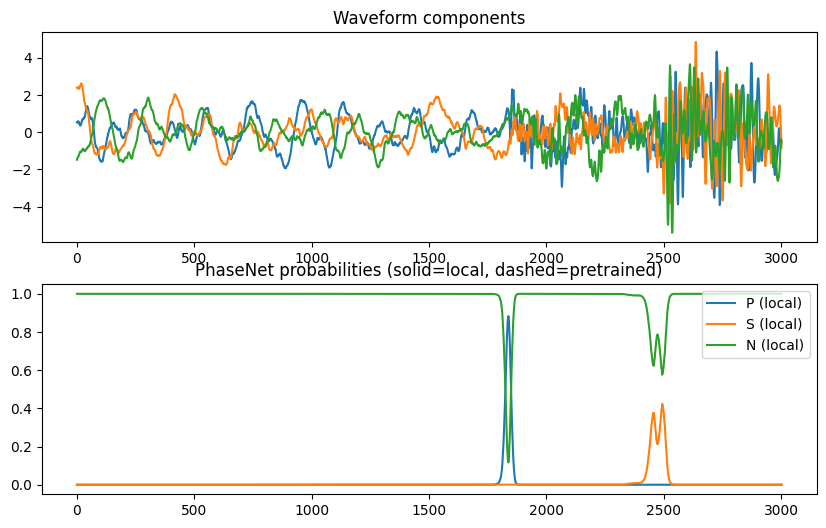

In [7]:
# plot results
wvno = 1
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
axes[0].plot(wv[wvno,:,:].T)
axes[0].set_title("Waveform components")
axes[1].plot(pred01[wvno,:,:].T)
axes[1].set_title("PhaseNet probabilities (solid=local, dashed=pretrained)")
axes[1].legend(["P (local)", "S (local)", "N (local)"], loc="upper right")

## Keras PhaseNet comparison

In [8]:
# pip install tensorflow
import models01.PhaseNet_Keras as phase_keras
import set_weight as sw

# Prepare data for Keras PhaseNet
wv_keras = np.transpose(wv, (0, 2, 1))

# Prepare Keras PhaseNet and transfer weights
model03 = phase_keras.PhaseNet(input_shape=(wv_keras.shape[1], wv_keras.shape[2]), n_class=3)
model03 = sw.set_weight_PhaseNet(model03, state_dict)
pred03 = model03.predict(wv_keras, verbose=0)
pred03 = np.transpose(pred03, (0, 2, 1))

max_diff_keras = np.max(np.abs(pred01 - pred03))
print(f"Local vs Keras-converted max |Δ| = {max_diff_keras:.3e}")

Local vs Keras-converted max |Δ| = 1.073e-06


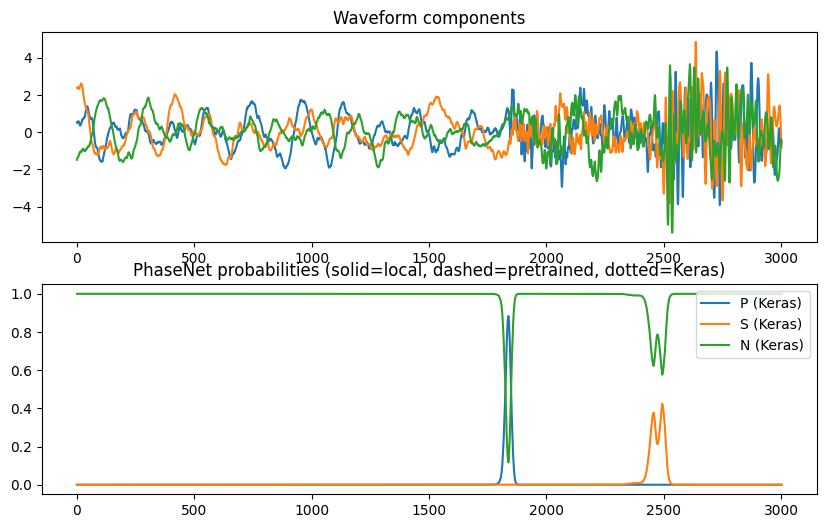

In [9]:
# Plot comparison including Keras output
wvno = 1
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
axes[0].plot(wv[wvno,:,:].T)
axes[0].set_title("Waveform components")
axes[1].plot(pred03[wvno,:,:].T, linestyle="-")
axes[1].set_title("PhaseNet probabilities (solid=local, dashed=pretrained, dotted=Keras)")
axes[1].legend(["P (Keras)", "S (Keras)", "N (Keras)"], loc="upper right")